In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import scipy.optimize as opt
import scipy.special as sp
import statsmodels.api as sm
import RMA

In [2]:
import matplotlib as mpl

In [3]:
%matplotlib inline

In [33]:
mpl.rcParams['font.family']='serif'
mpl.rcParams['font.serif'] = 'Times'
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['text.usetex']=True
mpl.rcParams['figure.figsize'] = (10,7.15)
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['legend.fontsize'] = 26
mpl.rcParams['legend.scatterpoints'] = 1
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markeredgewidth'] = 0
mpl.rcParams['figure.titlesize'] = 28
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['patch.linewidth'] = 1.0

In [5]:
df = pd.read_csv('../data/natureMcNab2008.csv')

In [6]:
df.columns

Index([u'Order', u'Family', u'Genus', u'Species', u'Genus Species',
       u'McNab Name', u'Mass (g)', u'BMR (W)', u'BMR (kJ/h)',
       u'Temperature (C)', u'Notes', u'Reference', u'Food', u'Climate',
       u'Habitat', u'Substrate', u'Torpor', u'Islands', u'Mountains',
       u'Tree Name', u'Notes.1'],
      dtype='object')

In [7]:
data = pd.DataFrame()
data_noT = pd.DataFrame()

In [8]:
data['Mass'] = df['Mass (g)']
data_noT['Mass'] = df['Mass (g)']

data['BMRW'] = df['BMR (W)']
data_noT['BMRW'] = df['BMR (W)']

data['BMRkjh'] = df['BMR (kJ/h)']
data_noT['BMRkjh'] = df['BMR (kJ/h)']

data['Temp'] = df['Temperature (C)']

data['constant'] = np.ones(len(df))
data_noT['constant'] = np.ones(len(df))

In [9]:
for c in data.columns:
    if c =='constant':
        continue
    data['log'+c] = np.log10(data[c])
    if c != 'Temp':
        data_noT['log'+c] = np.log10(data[c])
    if c =='Mass':
        data['log'+c+'sq'] = np.log10(data[c])**2
        data_noT['log'+c+'sq'] = np.log10(data[c])**2

In [10]:
data = data.dropna()

In [11]:
data_noT = data_noT.dropna()

In [12]:
data_noO = data.drop(data.Mass.idxmax())
data_noTnoO = data_noT.drop(data_noT.Mass.idxmax())

In [13]:
len(data),len(data_noT),len(data_noO),len(data_noTnoO)

(447, 637, 446, 636)

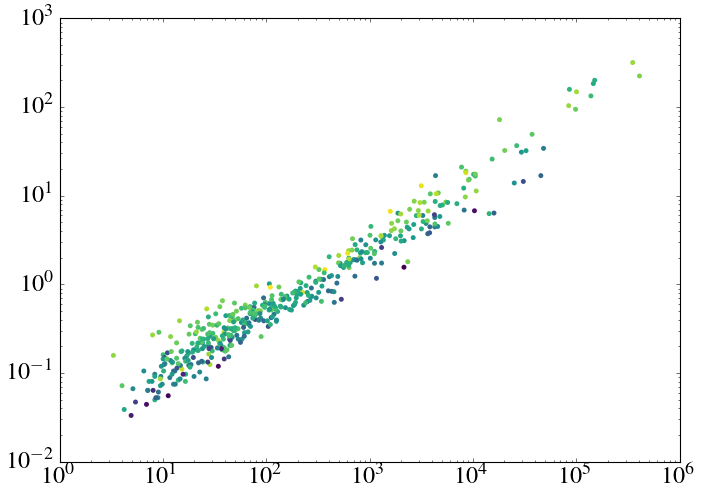

In [14]:
plt.scatter(data.Mass,data.BMRW,c=data.Temp,cmap=plt.get_cmap('viridis'))
plt.xscale('log')
plt.yscale('log')

In [15]:
RMA.RMARegression(data.logMass,data.logBMRW)

RMAResult(slope=0.72359546439967537, intercept=-1.7406845620252889, ci=0.95, slope_ci1=array([ 0.70869914,  0.73849179]), intercept_ci1=array([-1.77429816, -1.70707097]), slope_ci2=array([ 0.70885245,  0.73864511]), intercept_ci2=array([-1.77464411, -1.70741693]), RSquare=0.95117245328999933)

In [16]:
lin_model = sm.OLS(data_noTnoO.logBMRkjh,data_noTnoO[['logMass','constant']]).fit()
quad_model = sm.OLS(data_noTnoO.logBMRkjh,data_noTnoO[['logMasssq','logMass','constant']]).fit()

In [17]:
quad_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logBMRkjh   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     7706.
Date:                Wed, 25 Nov 2015   Prob (F-statistic):               0.00
Time:                        16:33:02   Log-Likelihood:                 264.88
No. Observations:                 636   AIC:                            -523.8
Df Residuals:                     633   BIC:                            -510.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
logMasssq      0.0322      0.005      7.013      0.000         0.023     0.041
logMass        0.5400      0.026     20.736      0.000         0.489     0.591
constant      -0.9515      0.032    -29.402      0.000        -1.015    -0.888
==============================================================================
Omnibus:                        5.878   Durbin-Watson:                   0.915
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                7.917
Skew:                          -0.018   Prob(JB):                       0.0191
Kurtosis:                       3.545   Cond. No.                         61.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
def inv(f,y_min,y_max):
    def f_inv(y):
        return opt.brenth(lambda x: f(x) - y,y_max,y_min)
    return f_inv

In [164]:
def WBEEx_inv(c,B):
    return c[0]*B + c[1]*B**(4./3.)

In [223]:
def WBEEx(c,M=data_noTnoO.Mass):
    def f(B):
        return c[0]*B + c[1]*B**(4./3.)
    B = []
    for m in M:
        try:
            b = opt.brenth(lambda b: f(b) - m,0.0001*data.BMRkjh.min(),1000*data.BMRkjh.max())
        except ValueError:
            B.append(np.inf)
        else:
            B.append(b)
    return np.array(B)
    

In [74]:
def FH(c,M=data_noTnoO.Mass):
    res = M/(c[1]*sp.lambertw((np.exp(c[0]/c[1])*M)/c[1]))
    return np.real(res)

In [238]:
def PT(c,M=data_noTnoO.Mass):
    if c[1] < 0 or c[2] < 0 or c[0] < 0:
        return np.inf*np.ones(len(M))
    p = c[3]
    def f(B):
        return c[0]*B + c[1]*B*np.log10(B) + c[2]*(B**p)
    B = []
    for m in M:
        try:
            b = opt.brenth(lambda b: f(b) - m,0.001*data.BMRkjh.min(),1000*data.BMRkjh.max())
        except ValueError:
            B.append(np.inf)
        else:
            B.append(b)
    return np.array(B)

In [151]:
def MFBE(c,M=data_noTnoO.Mass):
    c0 = c[0]
    c1 = c[1]
    dr = c[2]
    if dr < 0 or dr > 12:
        return np.inf*np.ones(len(M))
    a0 = (3.0/dr) - (5.0/4.0)
    a1 = (3.0/(2*dr)) + (1.0/12.0)
    return c0*(M**a0) + c1*(M**a1)

In [152]:
def sq_dist(c,f,X,Y):
    fX = f(c,X)
    if np.any(np.isinf(fX)) or np.any(np.isnan(fX)) or np.any(fX<=0):
        return np.inf
    return np.abs((np.log10(fX) - np.log10(Y))**2).sum()

In [208]:
def abs_dist(c,f,X,Y):
    fX = f(c,X)
    if np.any(np.isinf(fX)) or np.any(np.isnan(fX)) or np.any(fX<=0):
        return np.inf
    return np.abs((np.log10(fX) - np.log10(Y))).sum()

In [227]:
def min_dist(c,f,X,Y):
    fX = f(c,X)
    if np.any(np.isinf(fX)) or np.any(np.isnan(fX)) or np.any(fX<=0):
        return np.inf
    def dist(x,x0,y0):
        return (np.log10(x)-np.log10(x0))**2 + (np.log10(f(c,x))-np.log10(y0))**2
    tot = 0.0
    for x0,y0 in zip(X,Y):
        x = opt.fmin(dist,x0=x0,args=(x0,y0),disp=False)
        tot += dist(x,x0,y0)**2
    return tot

In [211]:
cWBEEx = opt.fmin(sq_dist,x0=[100,100],args=(WBEEx,data_noTnoO.Mass,data_noTnoO.BMRkjh))

Optimization terminated successfully.
         Current function value: 16.865456
         Iterations: 63
         Function evaluations: 120


In [212]:
cWBEEx_abs = opt.fmin(abs_dist,x0=[100,100],args=(WBEEx,data_noTnoO.Mass,data_noTnoO.BMRkjh))

Optimization terminated successfully.
         Current function value: 79.344896
         Iterations: 63
         Function evaluations: 121


In [213]:
cWBEEx,cWBEEx_abs

(array([-16.317941  ,  56.43422852]), array([-16.38437442,  57.80929311]))

In [228]:
cWBEEx_min = opt.fmin(min_dist,x0=[100,100],args=(WBEEx,data_noTnoO.Mass,data_noTnoO.BMRkjh))

Optimization terminated successfully.
         Current function value: 0.708208
         Iterations: 61
         Function evaluations: 121


In [229]:
cWBEEx_min

array([-15.36624848,  54.37794225])

In [231]:
cFH = opt.fmin(sq_dist,x0=[1.0,1.0],args=(FH,data_noTnoO.Mass,data_noTnoO.BMRkjh),maxiter=5000,xtol=10**-9,ftol=10**-9)

Optimization terminated successfully.
         Current function value: 17.636520
         Iterations: 101
         Function evaluations: 212


In [232]:
cFH_abs = opt.fmin(abs_dist,x0=[1.0,1.0],args=(FH,data_noTnoO.Mass,data_noTnoO.BMRkjh),maxiter=5000,xtol=10**-9,ftol=10**-9)

Optimization terminated successfully.
         Current function value: 80.173886
         Iterations: 129
         Function evaluations: 241


In [233]:
cFH_min = opt.fmin(min_dist,x0=[1.0,1.0],args=(FH,data_noTnoO.Mass,data_noTnoO.BMRkjh),maxiter=5000,xtol=10**-9,ftol=10**-9)

Optimization terminated successfully.
         Current function value: 0.835333
         Iterations: 106
         Function evaluations: 218


In [235]:
cPT = opt.fmin(sq_dist,x0=[1.0,0.0,1.0,4./3.],args=(PT,data_noTnoO.Mass,data_noTnoO.BMRkjh),maxiter=100000,xtol=10**-6,ftol=10**-6)

Optimization terminated successfully.
         Current function value: 17.450197
         Iterations: 397
         Function evaluations: 693


In [239]:
cPT_abs = opt.fmin(abs_dist,x0=cPT,args=(PT,data_noTnoO.Mass,data_noTnoO.BMRkjh),maxiter=100000,xtol=10**-6,ftol=10**-6)

Optimization terminated successfully.
         Current function value: 80.839111
         Iterations: 271
         Function evaluations: 494


In [240]:
cPT_min = opt.fmin(min_dist,x0=cPT,args=(PT,data_noTnoO.Mass,data_noTnoO.BMRkjh))

Optimization terminated successfully.
         Current function value: 0.753055
         Iterations: 228
         Function evaluations: 403


In [241]:
cPT,cPT_abs,cPT_min

(array([  4.34949143e-02,   4.91283788e-15,   4.02788951e+01,
          1.39283678e+00]),
 array([  4.78728582e-09,   1.58178729e-14,   4.17418921e+01,
          1.38965190e+00]),
 array([  1.47689181e-09,   1.34737510e-14,   3.87374223e+01,
          1.39077217e+00]))

In [181]:
cMFBE = opt.fmin(sq_dist,x0=[1.0,1.0,2.0],args=(MFBE,data_noTnoO.Mass,data_noTnoO.BMRkjh),maxiter=5000,xtol=10**-9,ftol=10**-9)

Optimization terminated successfully.
         Current function value: 16.750858
         Iterations: 169
         Function evaluations: 323


In [243]:
cMFBE_abs = opt.fmin(abs_dist,x0=[1.0,1.0,2.0],args=(MFBE,data_noTnoO.Mass,data_noTnoO.BMRkjh),maxiter=5000,xtol=10**-9,ftol=10**-9)

Optimization terminated successfully.
         Current function value: 79.028783
         Iterations: 246
         Function evaluations: 442


In [244]:
cMFBE_min = opt.fmin(min_dist,x0=[1.0,1.0,2.0],args=(MFBE,data_noTnoO.Mass,data_noTnoO.BMRkjh),maxiter=5000,xtol=10**-9,ftol=10**-9)

Optimization terminated successfully.
         Current function value: 0.717995
         Iterations: 260
         Function evaluations: 487


In [245]:
cMFBE,cMFBE_abs,cMFBE_min

(array([ 0.11407942,  0.04548941,  2.18449392]),
 array([ 0.1464175 ,  0.0303702 ,  2.03600913]),
 array([ 0.08476148,  0.05328374,  2.24056754]))

In [246]:
sBMR = np.logspace(np.log10(0.07),np.log10(2000),1000,base=10)
sMass = np.logspace(0,6,1000,base=10)

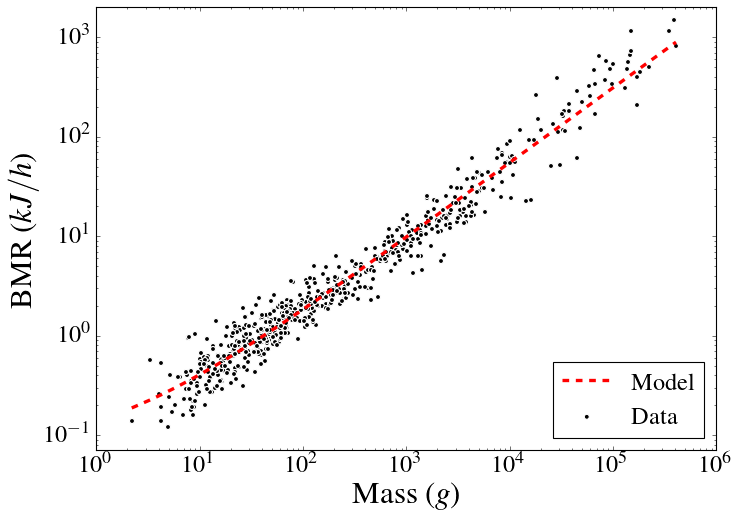

In [286]:
plt.scatter(data_noTnoO.Mass,data_noTnoO.BMRkjh,c='k',marker='o',edgecolor='w',label='Data')
plt.loglog(sMass,MFBE(cMFBE_min,sMass),'r--',lw=3,label='Model')
plt.xlim(1,10**6)
plt.ylim(0.07,2000)
plt.xlabel('Mass ($g$)')
plt.ylabel('BMR ($kJ/h$)')
plt.legend(loc='lower right',fontsize=22)

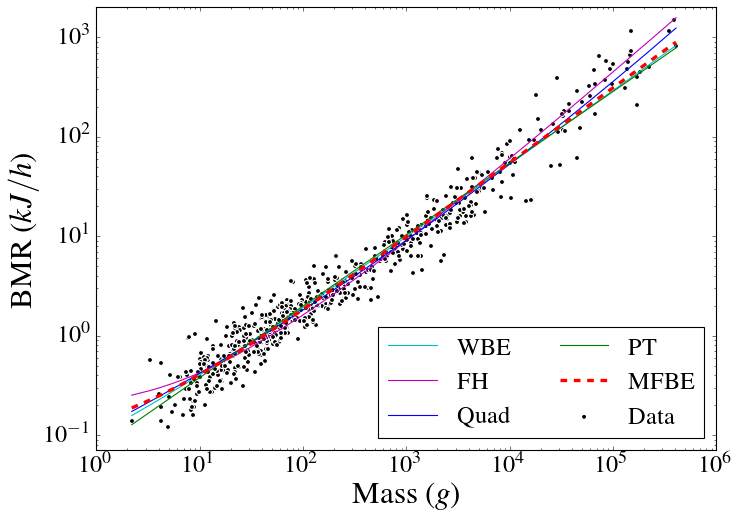

In [285]:
plt.scatter(data_noTnoO.Mass,data_noTnoO.BMRkjh,c='k',marker='o',edgecolor='w',label='Data')
plt.loglog(sMass,WBEEx(cWBEEx_min,sMass),'c-',lw=1,label='WBE')
plt.loglog(sMass,FH(cFH_min,sMass),'m-',lw=1,label='FH')
plt.loglog(sMass,10**quad_model.predict(np.c_[np.log10(sMass)**2,np.log10(sMass),np.ones(len(sMass))]),'b-',lw=1,label='Quad')
plt.loglog(sMass,PT(cPT_min,sMass),'g-',lw=1,label='PT')
plt.loglog(sMass,MFBE(cMFBE_min,sMass),'r--',lw=3,label='MFBE')
plt.xlim(1,10**6)
plt.ylim(0.07,2000)
plt.xlabel('Mass ($g$)')
plt.ylabel('BMR ($kJ/h$)')
plt.legend(loc='lower right',fontsize=22,ncol=2)

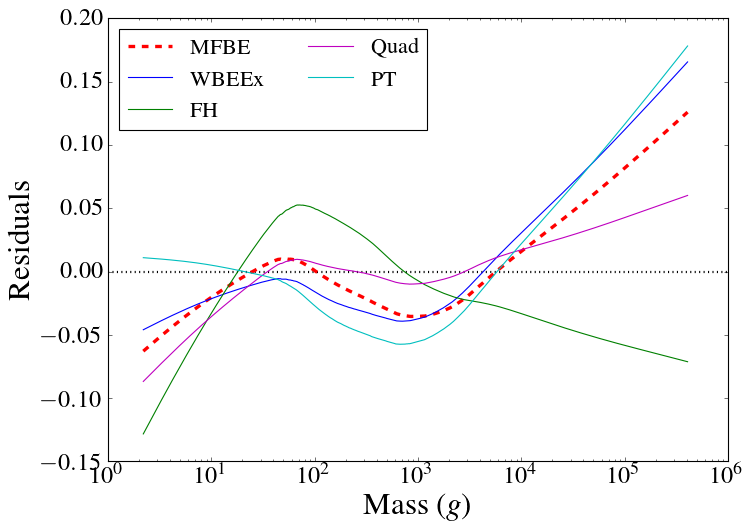

In [280]:
sMass = np.sort(data_noTnoO.Mass)
sBMR = np.log10(data_noTnoO.BMRkjh.values[np.argsort(np.log10(data_noTnoO.Mass))])
resid_quad = sBMR - quad_model.predict(np.c_[np.log10(sMass)**2,np.log10(sMass),np.ones(len(data_noTnoO.Mass))])
resid_WBEEx = sBMR - np.log10(WBEEx(cWBEEx_min,sMass))
resid_FH = sBMR - np.log10(FH(cFH_min,sMass))
resid_MFBE = sBMR - np.log10(MFBE(cMFBE_min,sMass))
resid_PT = sBMR - np.log10(PT(cPT_min,sMass))
#plt.semilogx(sMass,resid_MFBE,'k.',label='MFBE Residuals')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_MFBE,np.log10(sMass),return_sorted=False),'r--',lw=3,label='MFBE')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_WBEEx,np.log10(sMass),return_sorted=False),'b-',lw=1,label='WBEEx')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_FH,np.log10(sMass),return_sorted=False),'g-',lw=1,label='FH')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_quad,np.log10(sMass),return_sorted=False),'m-',lw=1,label='Quad')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_PT,np.log10(sMass),return_sorted=False),'c-',lw=1,label='PT')
plt.hlines(0,1,10**6,color='k',linestyle=':')
#plt.xlim(0,len(data_noTnoO))
plt.legend(loc='upper left',fontsize=20,ncol=2)
plt.xlabel('Mass ($g$)')
plt.ylabel('Residuals')

In [281]:
cMFBE_min

array([ 0.08476148,  0.05328374,  2.24056754])

In [282]:
cMFBE_abs

array([ 0.1464175 ,  0.0303702 ,  2.03600913])

In [283]:
cMFBE

array([ 0.11407942,  0.04548941,  2.18449392])

In [273]:
print((resid_MFBE**2).sum())
print((resid_quad**2).sum())
print((resid_FH**2).sum())
print((resid_PT**2).sum())
print((resid_WBEEx**2).sum())

16.8170026827
16.1896063561
17.8233835059
17.5594074141
16.9202700583


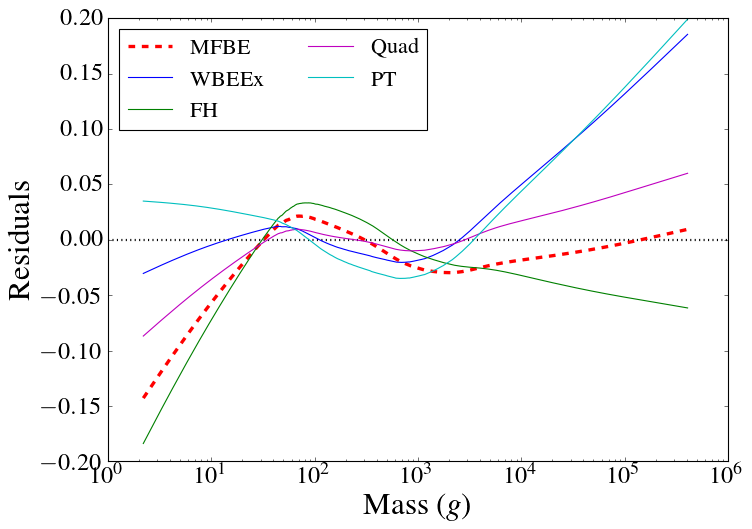

In [274]:
sMass = np.sort(data_noTnoO.Mass)
sBMR = np.log10(data_noTnoO.BMRkjh.values[np.argsort(np.log10(data_noTnoO.Mass))])
resid_quad = sBMR - quad_model.predict(np.c_[np.log10(sMass)**2,np.log10(sMass),np.ones(len(data_noTnoO.Mass))])
resid_WBEEx = sBMR - np.log10(WBEEx(cWBEEx_abs,sMass))
resid_FH = sBMR - np.log10(FH(cFH_abs,sMass))
resid_MFBE = sBMR - np.log10(MFBE(cMFBE_abs,sMass))
resid_PT = sBMR - np.log10(PT(cPT_abs,sMass))
#plt.plot(resid_MFBE,'k.')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_MFBE,np.log10(sMass),return_sorted=False),'r--',lw=3,label='MFBE')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_WBEEx,np.log10(sMass),return_sorted=False),'b-',lw=1,label='WBEEx')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_FH,np.log10(sMass),return_sorted=False),'g-',lw=1,label='FH')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_quad,np.log10(sMass),return_sorted=False),'m-',lw=1,label='Quad')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_PT,np.log10(sMass),return_sorted=False),'c-',lw=1,label='PT')
plt.hlines(0,1,10**6,color='k',linestyle=':')
#plt.xlim(0,len(data_noTnoO))
plt.legend(loc='upper left',fontsize=20,ncol=2)
plt.xlabel('Mass ($g$)')
plt.ylabel('Residuals')

In [275]:
print((resid_MFBE**2).sum())
print((resid_quad**2).sum())
print((resid_FH**2).sum())
print((resid_PT**2).sum())
print((resid_WBEEx**2).sum())

16.9778827007
16.1896063561
17.6563012031
17.5092276217
16.9188949757


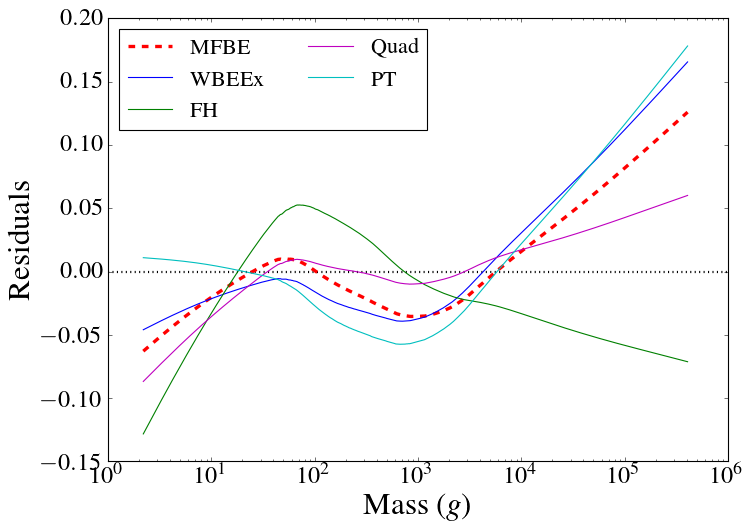

In [276]:
sMass = np.sort(data_noTnoO.Mass)
sBMR = np.log10(data_noTnoO.BMRkjh.values[np.argsort(np.log10(data_noTnoO.Mass))])
resid_quad = sBMR - quad_model.predict(np.c_[np.log10(sMass)**2,np.log10(sMass),np.ones(len(data_noTnoO.Mass))])
resid_WBEEx = sBMR - np.log10(WBEEx(cWBEEx_min,sMass))
resid_FH = sBMR - np.log10(FH(cFH_min,sMass))
resid_MFBE = sBMR - np.log10(MFBE(cMFBE_min,sMass))
resid_PT = sBMR - np.log10(PT(cPT_min,sMass))
#plt.plot(resid_MFBE,'k.')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_MFBE,np.log10(sMass),return_sorted=False),'r--',lw=3,label='MFBE')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_WBEEx,np.log10(sMass),return_sorted=False),'b-',lw=1,label='WBEEx')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_FH,np.log10(sMass),return_sorted=False),'g-',lw=1,label='FH')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_quad,np.log10(sMass),return_sorted=False),'m-',lw=1,label='Quad')
plt.semilogx(sMass,sm.nonparametric.lowess(resid_PT,np.log10(sMass),return_sorted=False),'c-',lw=1,label='PT')
plt.hlines(0,1,10**6,color='k',linestyle=':')
#plt.xlim(0,len(data_noTnoO))
plt.legend(loc='upper left',fontsize=20,ncol=2)
plt.xlabel('Mass ($g$)')
plt.ylabel('Residuals')

In [277]:
print((resid_MFBE**2).sum())
print((resid_quad**2).sum())
print((resid_FH**2).sum())
print((resid_PT**2).sum())
print((resid_WBEEx**2).sum())

16.8170026827
16.1896063561
17.8233835059
17.5594074141
16.9202700583


In [255]:
print(np.abs(resid_MFBE).sum())
print(np.abs(resid_quad).sum())
print(np.abs(resid_FH).sum())
print(np.abs(resid_PT).sum())
print(np.abs(resid_WBEEx).sum())

79.5210847978
77.573523823
81.1846041952
81.8199243029
79.9660188585
